In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selective-context 0.1.4 requires spacy==3.2.0, but you have spacy 3.7.4 which is incompatible.


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('A1_standard.csv')

In [ ]:
df

,sentence,label_text
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,"For the last quarter of 2010 , Componenta 's n...",positive
4,"In the third quarter of 2010 , net sales incre...",positive
...,...,...
2753,The company said that its comparable operating...,negative
2754,Operating result for the 12-month period decre...,negative
2755,HELSINKI Thomson Financial - Shares in Cargote...,negative
2756,LONDON MarketWatch -- Share prices ended lower...,negative


In [6]:
X = df['sentence']
y = df['label_text']
labels = list(set(df['label_text']))  # 获取唯一的标签
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

##one-hot
def onehotcodedata(examples):
    labels_matrix_df = pd.DataFrame(np.full((len(examples), len(labels)), False), columns=labels)
    for idx in range(len(labels_matrix_df)):
        labels_matrix_df.iloc[idx, labels.index(examples[idx])] = True
    return labels_matrix_df

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2, random_state=34790535)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                              stratify=y_train,
                                                              test_size=0.2, random_state=34790535)
y_train_train_m = onehotcodedata(y_train_train.to_numpy())
y_test_m = onehotcodedata(y_test.to_numpy())
y_val_m = onehotcodedata(y_val.to_numpy())

train = pd.DataFrame({'sentence': X_train_train.to_list(),
                      'positive': y_train_train_m['positive'],
                      'negative': y_train_train_m['negative'],
                      'neutral': y_train_train_m['neutral']})

validation = pd.DataFrame({'sentence': X_val.to_list(),
                           'positive': y_val_m['positive'],
                           'negative': y_val_m['negative'],
                           'neutral': y_val_m['neutral']})

test = pd.DataFrame({'sentence': X_test.to_list(),
                     'positive': y_test_m['positive'],
                     'negative': y_test_m['negative'],
                     'neutral': y_test_m['neutral']})


train.to_csv("my_train.csv", index=False)
test.to_csv("my_test.csv", index=False)
validation.to_csv("my_validation.csv", index=False)
from datasets import load_dataset
dataset_single = load_dataset("csv", data_files={"train": "my_train.csv", "test": "my_test.csv", "validation": "my_validation.csv"})




Generating train split: 1764 examples [00:00, 71445.49 examples/s]
Generating test split: 552 examples [00:00, 68216.14 examples/s]
Generating validation split: 442 examples [00:00, 60400.82 examples/s]


In [7]:
from transformers import AutoTokenizer
# 加载预训练的BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/public/jinweilin/bert-base-uncased")

def preprocess_data(examples):
    # 获取一批文本
    text = examples["sentence"]
    # 编码文本
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # 添加标签
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # 创建形状为 (batch_size, num_labels) 的 numpy 数组
    labels_matrix = np.zeros((len(text), len(labels)))
    # 填充 numpy 数组
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [8]:
# 在数据集上应用 preprocess_data 函数并移除原有列
encoded_dataset = dataset_single.map(preprocess_data, batched=True, remove_columns=dataset_single['train'].column_names)
encoded_dataset.set_format("torch")

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/mnt/public/jinweilin/bert-base-uncased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Map:   0%|          | 0/1764 [00:00<?, ? examples/s]

Map: 100%|██████████| 442/442 [00:00<00:00, 9972.63 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/public/jinweilin/bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
# 设置训练参数
batch_size = 8
metric_name = "f1"
args = TrainingArguments(
    output_dir="bert-finetuned-A1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

# 定义评估指标计算函数
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

def single_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, probs, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_macro, 'roc_auc': roc_auc, 'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    result = single_label_metrics(predictions=p.predictions, labels=p.label_ids)
    return result

# 创建Trainer实例并进行训练
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/mnt/jinweilin/anaconda3/envs/process/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.337717,0.765161,0.903253,0.776018
2,No log,0.276345,0.822488,0.939734,0.821267
3,0.326500,0.360353,0.808387,0.921664,0.825792
4,0.326500,0.385731,0.819664,0.930335,0.825792
5,0.084600,0.399288,0.807183,0.927934,0.816742


TrainOutput(global_step=1105, training_loss=0.1900979564200699, metrics={'train_runtime': 73.3766, 'train_samples_per_second': 120.202, 'train_steps_per_second': 15.059, 'total_flos': 580165086090240.0, 'train_loss': 0.1900979564200699, 'epoch': 5.0})

In [10]:
pred_result =trainer.evaluate(encoded_dataset["test"])
pred_result

{'eval_loss': 0.29086214303970337,
 'eval_f1': 0.8266893521065537,
 'eval_roc_auc': 0.9351106674696714,
 'eval_accuracy': 0.8242753623188406,
 'eval_runtime': 1.1709,
 'eval_samples_per_second': 471.416,
 'eval_steps_per_second': 58.927,
 'epoch': 5.0}

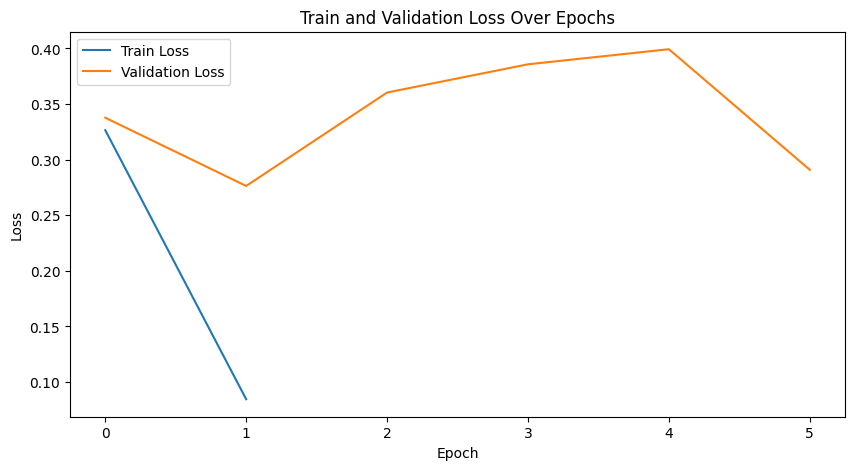

In [12]:
import matplotlib.pyplot as plt

# 提取训练过程中的损失记录
training_log = trainer.state.log_history

# 提取训练损失和验证损失
train_loss = [log["loss"] for log in training_log if "loss" in log.keys()]
validation_loss = [log["eval_loss"] for log in training_log if "eval_loss" in log.keys()]

# 绘制训练损失和验证损失
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss Over Epochs")
plt.legend()

In [13]:
from sklearn.metrics import roc_curve, auc

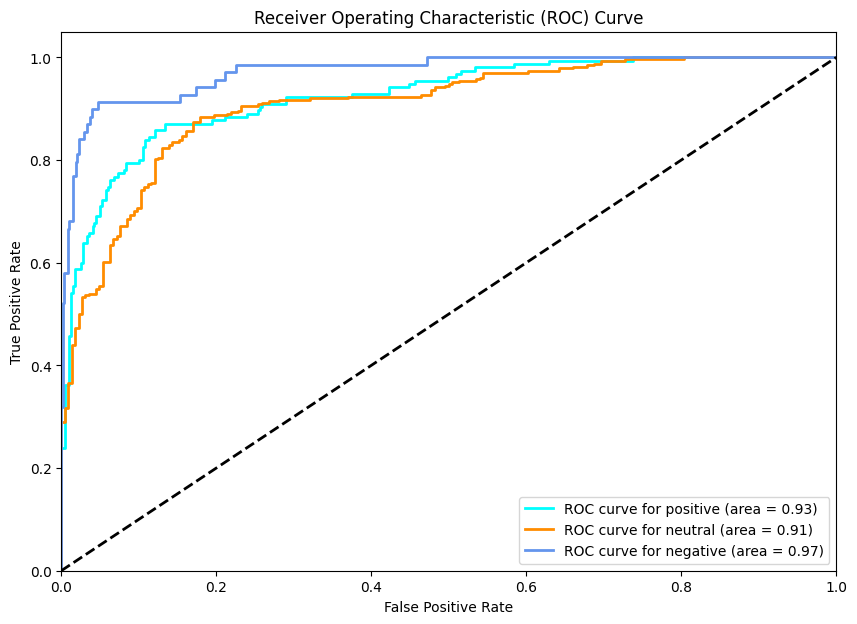

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取预测结果和真实标签
def get_predictions_and_labels(trainer, dataset):
    # 获取预测结果
    predictions = trainer.predict(dataset)
    # 预测概率
    preds = predictions.predictions
    # 真实标签
    labels = predictions.label_ids
    return preds, labels

# 使用验证集或测试集进行预测
preds, labels = get_predictions_and_labels(trainer, encoded_dataset["test"])

# 确保标签顺序为: positive, neutral, negative
label_names = ['positive', 'neutral', 'negative']

# 计算每个类别的 ROC 曲线和 AUC
n_classes = len(label_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


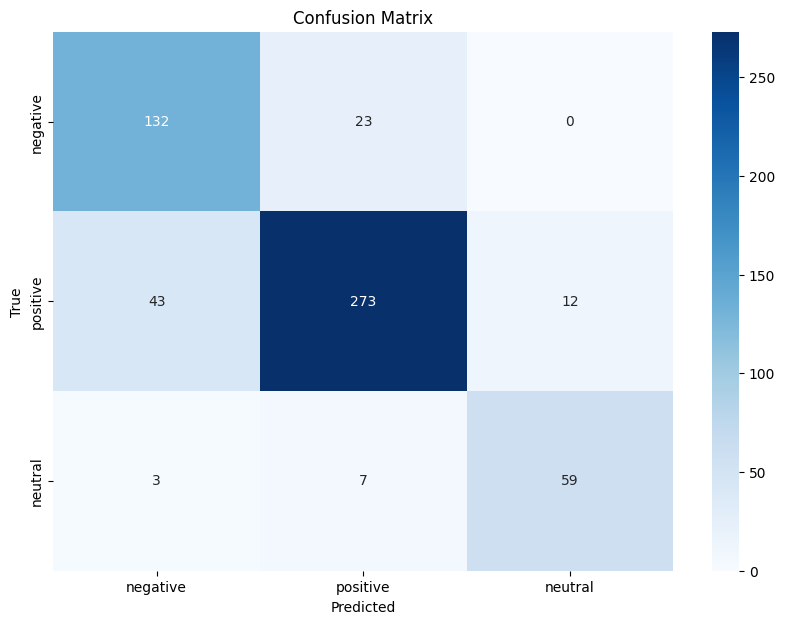

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 获取预测结果和真实标签
def get_predictions_and_labels(trainer, dataset):
    # 获取预测结果
    predictions = trainer.predict(dataset)
    # 预测标签
    preds = np.argmax(predictions.predictions, axis=1)
    # 真实标签
    labels = np.argmax(predictions.label_ids, axis=1)
    return preds, labels

# 使用测试集进行预测
preds, labels = get_predictions_and_labels(trainer, encoded_dataset["test"])

# 计算混淆矩阵
cm = confusion_matrix(labels, preds, labels=[0, 1, 2])

# 标签名称
label_names = ['negative','positive', 'neutral', ]

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# 获取预测结果和真实标签
def get_predictions_and_labels(trainer, dataset):
    # 获取预测结果
    predictions = trainer.predict(dataset)
    # 预测标签
    preds = np.argmax(predictions.predictions, axis=1)
    # 真实标签
    labels = np.argmax(predictions.label_ids, axis=1)
    return preds, labels

# 使用验证集或测试集进行预测
preds, labels = get_predictions_and_labels(trainer, encoded_dataset["test"])

# 标签名称
label_names = ['positive', 'neutral', 'negative']

# 生成分类报告
report = classification_report(labels, preds, target_names=label_names, output_dict=True)

# 打印每个类别的精确度、召回率和F1分数
for label in label_names:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    print(f'Precision for {label}: {precision:.2f}')
    print(f'Recall for {label}: {recall:.2f}')
    print(f'F1 score for {label}: {f1:.2f}')
    print()




Precision for positive: 0.74
Recall for positive: 0.85
F1 score for positive: 0.79

Precision for neutral: 0.90
Recall for neutral: 0.83
F1 score for neutral: 0.87

Precision for negative: 0.83
Recall for negative: 0.86
F1 score for negative: 0.84



In [18]:
# 打印加权平均F1分数
weighted_f1_score = report['weighted avg']['f1-score']
print(f'Weighted Average F1 Score: {weighted_f1_score:.2f}')

Weighted Average F1 Score: 0.84


##bert分词+CNN(1D)

In [7]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoTokenizer

# 加载预训练的BERT tokenizer
max_length = 40
tokenizer = AutoTokenizer.from_pretrained("/mnt/public/jinweilin/bert-base-uncased")

class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, dropout=0.5):
        super(CNN_Text, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout)

        # 计算卷积层输出的尺寸
        self.feature_dim = 256 * (max_length // 2)  # 40 是 max_length

        self.fc = nn.Linear(self.feature_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = x.permute(0, 2, 1)  # 转换维度以适应Conv1d: (batch_size, embedding_dim, sequence_length)
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.dropout(x)
        x = self.fc(x)
        return x

# 假设最大词汇表大小和嵌入维度
vocab_size = tokenizer.vocab_size
embedding_dim = 768  # 可以选择其他大小，但768通常是BERT的嵌入维度
num_classes = 3  # 假设有3个类别

# 创建模型实例
model = CNN_Text(vocab_size, embedding_dim, num_classes)

# 检查模型架构
print(model)



CNN_Text(
  (embedding): Embedding(30522, 768)
  (conv1d): Conv1d(768, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=5120, out_features=3, bias=True)
)


In [8]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',  # 使用 max_length 进行填充
            truncation=True,       # 使用 max_length 进行截断
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# 创建数据集和数据加载器
max_length = 40

# 假设你的texts和labels是之前使用的
texts = df['sentence'].tolist()
labels = [label2id[label] for label in df['label_text'].tolist()]  # 使用label2id将标签文本转换为数字

dataset = TextDataset(texts, labels, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# 训练模型
model.train()

for epoch in range(5):  # 假设训练5个epoch
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Training complete")




Epoch 1, Loss: 0.46554461121559143
Epoch 2, Loss: 0.6069143414497375
Epoch 3, Loss: 0.6364476084709167
Epoch 4, Loss: 0.7395889759063721
Epoch 5, Loss: 0.40330085158348083
Training complete


In [23]:
# # 获取预测结果和真实标签
# def get_predictions_and_labels(model, dataloader):
#     model.eval()
#     preds = []
#     labels = []
#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids = batch['input_ids']
#             attention_mask = batch['attention_mask']
#             label = batch['label']
#             output = model(input_ids, attention_mask)
#             pred = torch.argmax(output, dim=1)
#             preds.extend(pred.tolist())
#             labels.extend(label.tolist())
#     return preds, labels

# # 创建测试集数据加载器
# test_texts = df['sentence'].tolist()
# test_labels = [label2id[label] for label in df['label_text'].tolist()]  # 使用label2id将标签文本转换为数字

# test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_length)
# test_dataloader = DataLoader(test_dataset, batch_size=8)

# # 获取预测结果和真实标签
# preds, true_labels = get_predictions_and_labels(model, test_dataloader)

# # 标签名称
# label_names = ['positive', 'neutral', 'negative']

# # 生成分类报告
# report = classification_report(true_labels, preds, target_names=label_names, output_dict=True)

# # 打印每个类别的精确度、召回率和F1分数
# for label in label_names:
#     precision = report[label]['precision']
#     recall = report[label]['recall']
#     f1 = report[label]['f1-score']
#     print(f'Precision for {label}: {precision:.2f}')
#     print(f'Recall for {label}: {recall:.2f}')
#     print(f'F1 score for {label}: {f1:.2f}')
#     print()

# # 打印加权平均F1分数
# weighted_f1_score = report['weighted avg']['f1-score']
# print(f'Weighted Average F1 Score: {weighted_f1_score:.2f}')
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# 获取预测结果和真实标签
def get_predictions_and_labels(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['label']
            output = model(input_ids, attention_mask)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.tolist())
            labels.extend(label.tolist())
    return preds, labels


In [24]:
# 创建测试集数据加载器
test_texts = df['sentence'].tolist()
test_labels = [label2id[label] for label in df['label_text'].tolist()]  # 使用label2id将标签文本转换为数字

test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# 获取预测结果和真实标签
preds, true_labels = get_predictions_and_labels(model, test_dataloader)


In [25]:
# 生成分类报告
report = classification_report(true_labels, preds, target_names=label_names, output_dict=True)

# 打印每个类别的精确度、召回率和F1分数
for label in label_names:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    print(f'Precision for {label}: {precision:.2f}')
    print(f'Recall for {label}: {recall:.2f}')
    print(f'F1 score for {label}: {f1:.2f}')
    print()

# 打印加权平均F1分数
weighted_f1_score = report['weighted avg']['f1-score']
print(f'Weighted Average F1 Score: {weighted_f1_score:.2f}')


Precision for positive: 0.83
Recall for positive: 0.55
F1 score for positive: 0.66

Precision for neutral: 0.75
Recall for neutral: 1.00
F1 score for neutral: 0.85

Precision for negative: 0.97
Recall for negative: 0.19
F1 score for negative: 0.32

Weighted Average F1 Score: 0.73


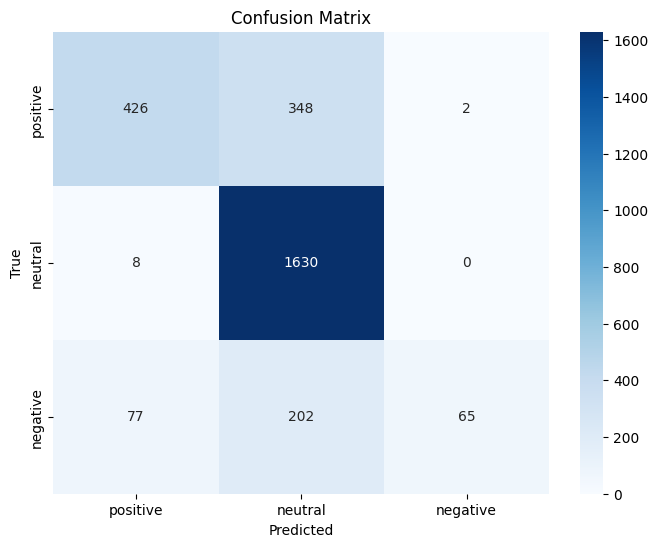

In [26]:
# 生成混淆矩阵
cm = confusion_matrix(true_labels, preds)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


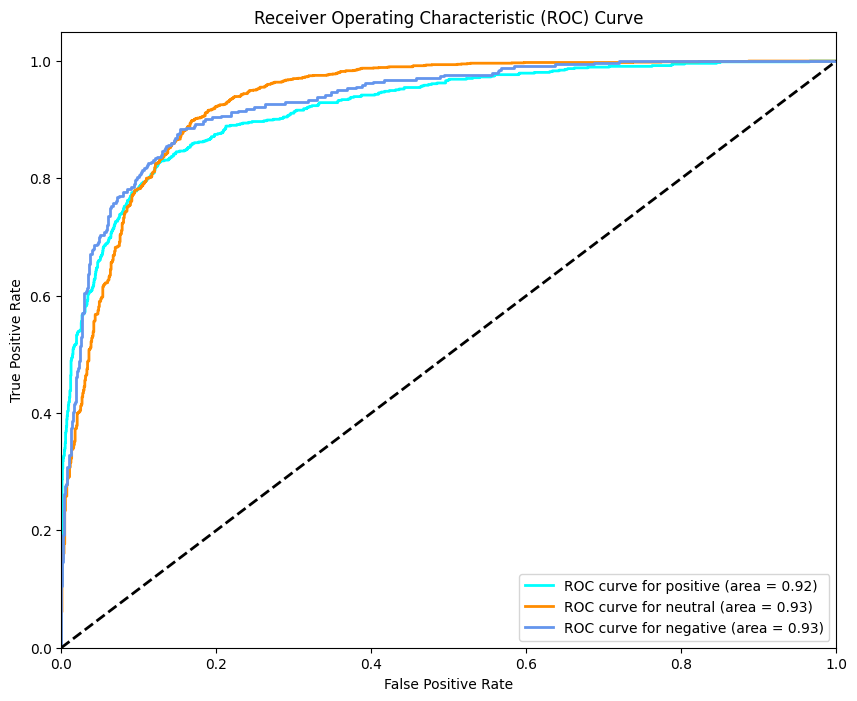

In [27]:
# 获取预测概率
def get_predictions_and_probabilities(model, dataloader):
    model.eval()
    probs = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['label']
            output = model(input_ids, attention_mask)
            prob = torch.nn.functional.softmax(output, dim=1)
            probs.extend(prob.tolist())
            labels.extend(label.tolist())
    return probs, labels

# 获取预测概率和真实标签
probs, true_labels = get_predictions_and_probabilities(model, test_dataloader)

# 转换为numpy数组
probs = np.array(probs)
true_labels = np.array(true_labels)

# 计算每个类别的ROC曲线和AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(label_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


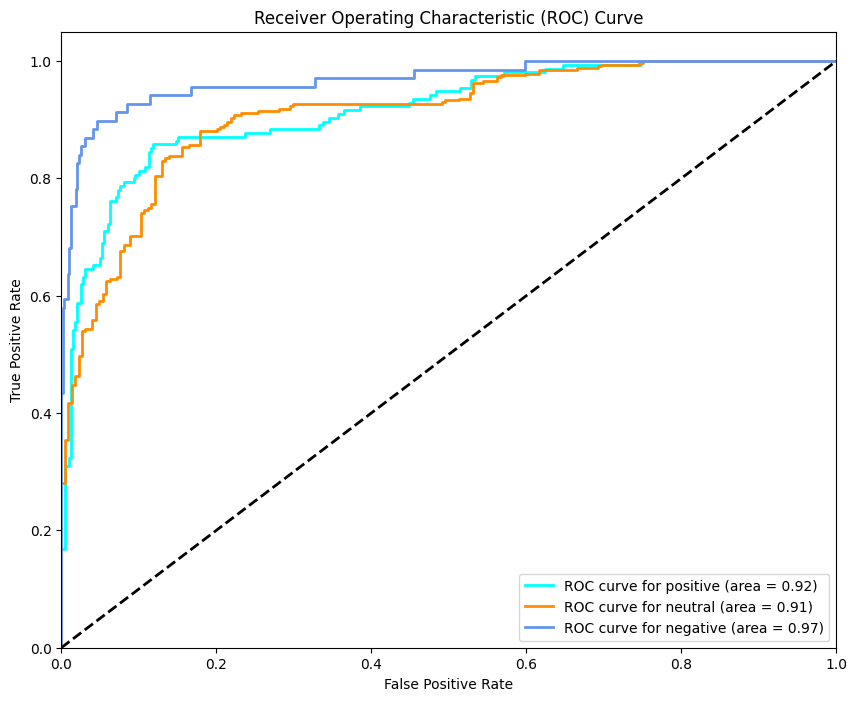

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch

# 获取预测概率
def get_predictions_and_probabilities(trainer, dataset):
    # 获取预测结果
    predictions = trainer.predict(dataset)
    # 预测概率
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
    # 真实标签
    labels = np.argmax(predictions.label_ids, axis=1)
    return probs, labels

# 获取预测概率和真实标签
probs, true_labels = get_predictions_and_probabilities(trainer, encoded_dataset["test"])

# 转换为numpy数组
probs = np.array(probs)
true_labels = np.array(true_labels)

# 计算每个类别的ROC曲线和AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(label_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
